# ISYS2407 Information Systems Solutions & Design

# My Model Training 1 : Random Forest (Decision Tree)

# Selected Features

#### Student name: Thao Vy LE

#### Student number: S3970577


# I. Binary Classification 

## 1 Import Libraries

In [1]:
# Library for pickling
import joblib

# Library needed for counting categorical values
import collections

# Library for splitting the data into train and test sets
from sklearn.model_selection import train_test_split 

# Model library
from sklearn.linear_model import LogisticRegression

# Scaling
from sklearn.preprocessing import StandardScaler

# label encoder
from sklearn.preprocessing import LabelEncoder

# Onehot encoding
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np

# Metrics library
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# Libraries to select k best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### 1.1 Import the model library: Random Forest 

In [2]:
# Import the model library
from sklearn.ensemble import RandomForestClassifier

### 1.4 Load the cleaned pkl file

In [3]:
# Load the pickled file
personal_loan_df = joblib.load('cleaned_personal_loan.pkl')  

# Check
personal_loan_df.head()

,customer_id,age,yrs_experience,family_size,education_level,income,mortgage_amt,credit_card_acct,credit_card_spend,share_trading_acct,fixed_deposit_acct,online_acct,personal_loan
0,3815,40.0,9.0,3.0,1,60.0,0.0,1,0.0,0,0,1,0
1,5737,65.0,27.0,4.0,2,36.0,90.0,0,0.0,0,0,1,0
2,4209,61.0,3.0,2.0,0,145.0,0.0,0,0.0,0,1,1,1
3,4734,29.0,14.0,1.0,0,52.0,0.0,0,0.0,1,0,1,0
4,2551,43.0,23.0,4.0,1,33.0,0.0,0,0.0,0,0,1,0


### 1.5 Splitting data for testing and training

In [4]:
# Features are variables that affect the target/label
# So, it's all the columns excluding the target column
# Featured excluded: credit_card_acct, credit_card_spend, online_acct
feature_cols = [
    'age', 
    'yrs_experience', 
    'family_size', 
    'education_level',
    'income', 
    'mortgage_amt',
    'share_trading_acct',
    'fixed_deposit_acct'
]

X = personal_loan_df[feature_cols]
#print('X:\n', X)

# Store the labels/target in variable y (lower case as its a single value)
y = personal_loan_df['personal_loan']
#print('y:\n', y)

# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # keep 20% for testing, rest for training
                                                    random_state=2 # pass an int for reproducible rtesult
                                                    )

In [5]:
# Check splitted training/testing set
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4800, 8) (4800,)
(1200, 8) (1200,)


In [6]:
# Check the data shape
print(personal_loan_df.shape)
print(personal_loan_df.columns)

(6000, 13)
Index(['customer_id', 'age', 'yrs_experience', 'family_size',
       'education_level', 'income', 'mortgage_amt', 'credit_card_acct',
       'credit_card_spend', 'share_trading_acct', 'fixed_deposit_acct',
       'online_acct', 'personal_loan'],
      dtype='object')


## 2 Data Transformation

### 2.1 Scaling: Create copy of X_train and X_test

In [7]:
# 1. Select the columns to scale
# Make sure they are continuous columns as scaling is only for continuous values
# Remove 'income'
columns_to_scale = [
    'age',
    'yrs_experience',
    'family_size',
    'education_level',
    'mortgage_amt',
    'share_trading_acct',
    'fixed_deposit_acct'
]

# 2. Make copy of the training and testing sets fix the issue below
# Warning: A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead
X_train = X_train.copy()
X_test = X_test.copy()

# 3. Instantiate a scaler
scaler = StandardScaler()
    
# 4. Fit the scaler on the training column and transform the training and testing columns
# Use a loop to scale all the required columns    
for col in columns_to_scale:
    #print(col)
    # First fit the scaler to the column in the training data
    # Must reshape the numpy array returned b the scaler from 1D to 2D
    scaler.fit(X_train[col].values.reshape(-1, 1))
    # Then transform both the training and testing sets
    X_train[col] = scaler.transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

# Check
print(X_train.shape, X_test.shape)

(4800, 8) (1200, 8)


In [8]:
# Check again
X_train.head()

,age,yrs_experience,family_size,education_level,income,mortgage_amt,share_trading_acct,fixed_deposit_acct
2973,1.461735,-0.802635,-1.215152,-1.061242,19.0,-0.784341,-0.326735,-0.287729
2774,-0.826882,1.387036,1.312027,-1.061242,144.0,-0.784341,-0.326735,-0.287729
3281,-0.908618,1.308833,-0.372759,1.323572,55.0,-0.784341,-0.326735,-0.287729
2512,1.379999,-0.724432,-1.215152,-1.061242,94.0,-0.784341,-0.326735,-0.287729
457,0.971317,0.839618,1.312027,0.131165,70.0,-0.784341,-0.326735,-0.287729


### 2.2 Discretization of continuous values

In [9]:
# When checking the number of unique values, the income column was found to contain 257 values
# This is evidence that it's a continuous variable

# For income we could use the following: #Low: <$26000
#Low-Medium: $26,000 - $51,999 
#Medium: $52,000 - $77,999 /Medium-High: $78,000 - $103,999/ otherwise superhigh
#Individual income in City of Melbourne: https://profile.id.com.au/melbourne/individual-income
#Household income in City of Melbourne: https://profile.id.com.au/melbourne/household-income
#Earnings and working conditions (Australia-wide): https://www.abs.gov.au/statistics/labour/earnings-and-working-conditions

# Define a function to classify this
# Pass the whole dataframe as parameter
# And return a category (a word label but you could also return numeric labels)
# NOTE: Do not create too many categories as this will affect the learning algorithms

def income_category(df):
    if df["income"] <= 26:
        return "low_income"
    elif (df["income"] > 26) & (df["income"] <= 103.9):
        return "medium_income"
    elif df["income"] > 103.9:
        return "high_income"
        

In [10]:
# Apply the  previously defined function to the training set

# Use apply() to apply a lambda function for all the rows of the dataframe
# The lambda function calls the previously defined function bp_category()
# To which it passes the diabetes_df as parameter
# And a category is returned and saved in a new column named "blood_pressure_category"
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
# the backslash is a line continuation character - there should be nothing after it, not even a space

# Warning: A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead
# Below is another fix - make a copy
X_train = X_train.copy()
X_train["income_category"] = \
    X_train.apply(lambda X_train:income_category(X_train), axis = 1) # axis=1 = row-wise

# The column "blood_pressure" is no longer needed and hence can be deleted 
X_train.drop(['income'], axis=1, inplace=True)

# Check
X_train.head()

,age,yrs_experience,family_size,education_level,mortgage_amt,share_trading_acct,fixed_deposit_acct,income_category
2973,1.461735,-0.802635,-1.215152,-1.061242,-0.784341,-0.326735,-0.287729,low_income
2774,-0.826882,1.387036,1.312027,-1.061242,-0.784341,-0.326735,-0.287729,high_income
3281,-0.908618,1.308833,-0.372759,1.323572,-0.784341,-0.326735,-0.287729,medium_income
2512,1.379999,-0.724432,-1.215152,-1.061242,-0.784341,-0.326735,-0.287729,medium_income
457,0.971317,0.839618,1.312027,0.131165,-0.784341,-0.326735,-0.287729,medium_income


In [11]:
# Apply the  previously defined function to the testing set
X_test = X_test.copy()
X_test["income_category"] = \
    X_test.apply(lambda X_test:income_category(X_test), axis = 1) # axis=1 = row-wise

# The column "blood_pressure" is no longer needed and hence can be deleted 
X_test.drop(['income'], axis=1, inplace=True)

# Check
X_test.head()

,age,yrs_experience,family_size,education_level,mortgage_amt,share_trading_acct,fixed_deposit_acct,income_category
1637,1.298262,0.448606,-1.215152,0.131165,1.359831,-0.326735,-0.287729,low_income
1381,-1.807718,0.839618,-1.215152,1.323572,1.864342,-0.326735,-0.287729,medium_income
2714,-1.562509,-1.115445,-1.215152,1.323572,2.318402,-0.326735,-0.287729,medium_income
2556,-0.908618,0.448606,-0.372759,-1.061242,-0.784341,-0.326735,-0.287729,medium_income
586,0.072217,-0.020610,-0.372759,-1.061242,-0.784341,-0.326735,-0.287729,medium_income


### 2.3 Encode the discretized values

In [12]:
# 1. Select the columns to one-hot encode
# Make sure the columns are categorical columns with multiple labels 
# It does not matter whether the labels are words or numbers
# Better list all the columns and comment out the ones you don't need
columns_to_onehot_encode = [
    #'num_pregnancies', 
    #'glucose', 
    #'blood_pressure', # this column no longer exists
    'income_category'
    
]

# 2 Instantiate a one-hot encoder
#enc = OneHotEncoder() # No, this will generate strings, not numbers
enc = LabelBinarizer()

# 3. Fit the encoder on the training column and transform the training and testing columns
# Use a loop to label encode all the required columns 
for col in columns_to_onehot_encode:
    # Option 1. Using pandas (simpler than sklearn)
    ## Fix X_train
    dummies_df = pd.get_dummies(X_train[col], prefix="bpc", dtype=int ) # generate dataframe of dummies
    X_train.drop([col], axis=1, inplace=True) # drop original column
    X_train = pd.concat([X_train, dummies_df], axis=1) # concatenate both dataframes
    ## Fix X_test
    dummies_df = pd.get_dummies(X_test[col], prefix="bpc", dtype=int )
    X_test.drop([col], axis=1, inplace=True)
    X_test = pd.concat([X_test, dummies_df], axis=1)
    
    # Option 2: Using sklearn    
    # First fit the encoder to the training data
    #enc.fit(X_train[col].values.reshape(-1, 1)) # need to reshape
    #X_train_array = enc.transform(X_train[col])
    #X_test_array = enc.transform(X_test[col])
    #print(X_train_array)
    #print(X_train_array)
    # numpy arrays generated - have no column names and columns not in any particular order
    # need to write complex code to generate column names for variable number of columns
    # to be able to convert the numpy array to a daframe
    # Better use the pandas solution!
     
# Check
X_train.head()

,age,yrs_experience,family_size,education_level,mortgage_amt,share_trading_acct,fixed_deposit_acct,bpc_high_income,bpc_low_income,bpc_medium_income
2973,1.461735,-0.802635,-1.215152,-1.061242,-0.784341,-0.326735,-0.287729,0,1,0
2774,-0.826882,1.387036,1.312027,-1.061242,-0.784341,-0.326735,-0.287729,1,0,0
3281,-0.908618,1.308833,-0.372759,1.323572,-0.784341,-0.326735,-0.287729,0,0,1
2512,1.379999,-0.724432,-1.215152,-1.061242,-0.784341,-0.326735,-0.287729,0,0,1
457,0.971317,0.839618,1.312027,0.131165,-0.784341,-0.326735,-0.287729,0,0,1


In [13]:
# Check
X_test.head()

,age,yrs_experience,family_size,education_level,mortgage_amt,share_trading_acct,fixed_deposit_acct,bpc_high_income,bpc_low_income,bpc_medium_income
1637,1.298262,0.448606,-1.215152,0.131165,1.359831,-0.326735,-0.287729,0,1,0
1381,-1.807718,0.839618,-1.215152,1.323572,1.864342,-0.326735,-0.287729,0,0,1
2714,-1.562509,-1.115445,-1.215152,1.323572,2.318402,-0.326735,-0.287729,0,0,1
2556,-0.908618,0.448606,-0.372759,-1.061242,-0.784341,-0.326735,-0.287729,0,0,1
586,0.072217,-0.020610,-0.372759,-1.061242,-0.784341,-0.326735,-0.287729,0,0,1


# Build the Random Forest model

In [14]:
# Instantiate model RandomForest and fit on training data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Use the testing set (i.e., X_test) to make predictions
y_pred = rf_model.predict(X_test)


# Print the hyperparameters of the model
# The parameters should be tuned later to get an optimal model
print(rf_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [15]:
# Compare the actual (true) labels or categories with the predicted ones
print('True:', y_test.values[0:25])
print('Pred:', y_pred[0:25])

True: [0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1]
Pred: [0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


# II. Performance metrics

### 2.1 Performance Metrics

In [16]:
#classification accuracy test
classification_accuracy = accuracy_score(y_test, y_pred)
print(f"classification accuracy: {classification_accuracy}")
print(f"Is this a good classifier?")

classification accuracy: 0.89
Is this a good classifier?


In [17]:
# Null accuracy
# y_test = list of labels in the testing set
# y_pred = extracted from the model

# This formula will only work for binary classification problems
null_accuracy = max(y_test.mean(), 1 - y_test.mean())
print(f"null accuracy: {null_accuracy}")
print(f"No machine learning was used to build this classifer!")

null accuracy: 0.8383333333333334
No machine learning was used to build this classifer!


In [18]:
#confusion matrix
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n {cf_matrix}")  # \n means new line i.e. next line

# Interpretation of the confusion matrix
print("There are a lot of cases that are mis-classified.")
print(f"{cf_matrix[0, 1]} cases are classified as positives when they are not - called false positives (FP)")
print(f"{cf_matrix[1, 0]} cases are classified as negatives when they are not - called false negatives (FN)")
print("A FP means you are telling someone that he approved the loan when he doesn't have it.")
print("A FN means you are telling someone that he did not accept the loan offer when in fact he has it.")
print("If you had to minimise FP and FN, which one would you choose in this context?")


Confusion Matrix:
 [[966  40]
 [ 92 102]]
There are a lot of cases that are mis-classified.
40 cases are classified as positives when they are not - called false positives (FP)
92 cases are classified as negatives when they are not - called false negatives (FN)
A FP means you are telling someone that he approved the loan when he doesn't have it.
A FN means you are telling someone that he did not accept the loan offer when in fact he has it.
If you had to minimise FP and FN, which one would you choose in this context?


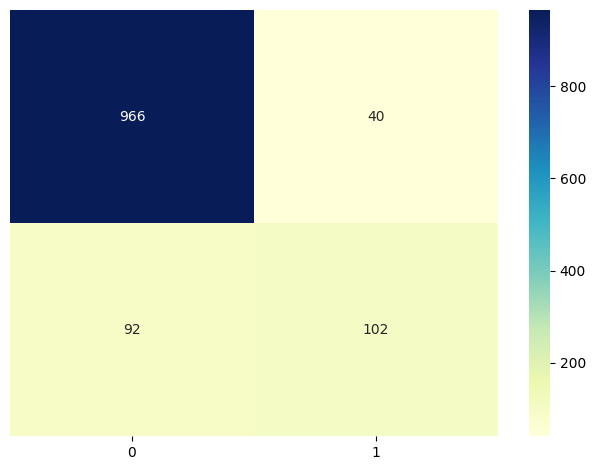

In [19]:
# Visualise the confusion matrix as a Seaborn Heatmap
sns.heatmap(cf_matrix, annot=True, fmt="d", yticklabels=False, cmap="YlGnBu")

# If you want to save the graph to disk
plt.tight_layout() # automatically adjusts subplot to fit in the figure area
plt.savefig('03-confusion-matrix-initial.png', dpi=300) # dpi=300 is print quality

In [20]:
#Recall
recall = recall_score(y_test, y_pred)
print(f"recall: {recall}") # the closer to 1 the more accurate

recall: 0.5257731958762887


In [21]:
#Precision
precision = precision_score(y_test, y_pred)
print(f"precision: {precision}")

precision: 0.7183098591549296


In [22]:
#F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 score: {f1}")

F1 score: 0.6071428571428571


In [23]:
# Method2. Use numpy's ravel() function to flatten the 2D confusion matrix to a 1D array
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Print
print(f"tn {tn}")
print(f"fp {fp}" )
print(f"fn {fn}")
print(f"tp {tp}")

# Precision
precision = tp / (tp + fp)
print(f"precision: {precision}")

# Recall
recall = tp / (tp + fn)
print(f"recall: {recall}")

# F1
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 score: {f1}")

tn 966
fp 40
fn 92
tp 102
precision: 0.7183098591549296
recall: 0.5257731958762887
F1 score: 0.6071428571428571


In [24]:
#Scikit-Learn's classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1006
           1       0.72      0.53      0.61       194

    accuracy                           0.89      1200
   macro avg       0.82      0.74      0.77      1200
weighted avg       0.88      0.89      0.88      1200



AUC: 0.74


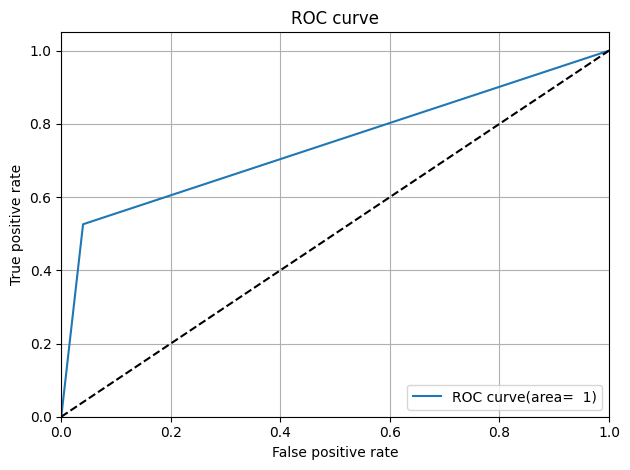

In [25]:
#AUC and ROC curve

# Call function roc_curve() to get the false positive rates (fpr) and true positive rates
# Need to pass the list of actual and predicted classes as parameters to the function
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
#print(fpr)
#print(tpr)

# Call the auc() function to calculate the area under the curve
# Need to pass the false positive rates (fpr) and true positive rates as parameters to the function
roc_auc = auc(fpr,tpr)
print(f'AUC: {roc_auc:0.2f}') # float 2 places of decimal

# Plot ROC curve
plt.figure()
plt.plot(fpr,tpr,label='ROC curve(area= %2.f)' %roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
#plt.show()

# If you want to save the graph to disk
plt.tight_layout() # automatically adjusts subplot to fit in the figure area
plt.savefig('roc-curve-initial.png', dpi=300) # dpi=300 is print quality

In [27]:
# Pickle the model for later evaluation
joblib.dump(rf_model, 'model-test-1-selected')  # Use the right model name and a suitable file name

# Also need to pickle the training and testing sets
joblib.dump(X_train, 'X_train_1_selected.pkl') 
joblib.dump(X_test, 'X_test_1_selected.pkl') 
joblib.dump(y_train, 'y_train_1_selected.pkl') 
joblib.dump(y_test, 'y_test_1_selected.pkl')

# Note: make sure that the model and the training/testing sets match 
# i.e. the model was built using this particular training set
# and the testing set matches this particular training

['y_test_1_selected.pkl']